##Cell 1: Import Libraries and Set Random Seeds

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

# Set random seeds for reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


Cell 2: Define Symbolic Functions

In [10]:
# Define multiple symbolic functions
def symbolic_function_1(x):
    return np.sin(5 * x) * np.exp(-x**2)

def symbolic_function_2(x):
    return np.where(x < 0, np.sin(5 * x), np.cos(5 * x)) * np.exp(-x**2)

def symbolic_function_3(x):
    return np.abs(np.sin(5 * x)) * np.exp(-x**2)

def symbolic_function_4(x):
    return np.sin(10 * x) * np.exp(-x**2)

def symbolic_function_5(x):
    return np.sin(15 * x) * np.exp(-x**2)

def symbolic_function_6(x):
    return np.piecewise(x, [x < 0, x >= 0], [lambda x: np.sin(5 * x), lambda x: np.sin(5 * x) + 1]) * np.exp(-x**2)

# Dictionary of functions for easy access
functions = {
    'Function 1': symbolic_function_1,
    'Function 2': symbolic_function_2,
    'Function 3': symbolic_function_3,
    'Function 4': symbolic_function_4,
    'Function 5': symbolic_function_5,
    'Function 6': symbolic_function_6,
}


Cell 3: Data Generation Function

In [11]:
def generate_data(symbolic_function, n_samples=1000):
    x_values = np.linspace(-2, 2, n_samples)
    np.random.shuffle(x_values)
    y_values = symbolic_function(x_values)

    # Split into train, validation, and test sets
    train_split = int(0.7 * n_samples)
    val_split = int(0.85 * n_samples)

    x_train = x_values[:train_split]
    y_train = y_values[:train_split]

    x_val = x_values[train_split:val_split]
    y_val = y_values[train_split:val_split]

    x_test = x_values[val_split:]
    y_test = y_values[val_split:]

    # Normalize inputs
    x_mean = x_train.mean()
    x_std = x_train.std()
    x_train = (x_train - x_mean) / x_std
    x_val = (x_val - x_mean) / x_std
    x_test = (x_test - x_mean) / x_std

    # Convert to tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

    x_val_tensor = torch.tensor(x_val, dtype=torch.float32).unsqueeze(1).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)

    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

    # Create data loaders
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

    return train_loader, val_loader, test_loader, x_test, y_test


Cell 4: Define the MLP Model

In [12]:
# MLP Model Definition
class MLP(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=20, output_dim=1):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)


Cell 5: Define the BSpline Activation and KAN Model

In [13]:
# BSpline Activation Function
class BSplineActivation(nn.Module):
    def __init__(self, num_parameters=20, init_range=(-1, 1)):
        super(BSplineActivation, self).__init__()
        # Initialize control points
        self.control_points = nn.Parameter(torch.linspace(init_range[0], init_range[1], num_parameters))
        # Initialize weights
        self.weights = nn.Parameter(torch.randn(num_parameters))

    def forward(self, x):
        # Apply the B-spline approximation using linear interpolation
        x_clipped = torch.clamp(x, self.control_points[0].item(), self.control_points[-1].item())
        indices = torch.bucketize(x_clipped.detach(), self.control_points.detach())
        indices = torch.clamp(indices, 1, len(self.control_points) - 1)

        x0 = self.control_points[indices - 1]
        x1 = self.control_points[indices]
        y0 = self.weights[indices - 1]
        y1 = self.weights[indices]

        slope = (y1 - y0) / (x1 - x0 + 1e-6)
        output = y0 + slope * (x_clipped - x0)
        return output

# KAN Model Definition
class KAN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=20, output_dim=1, num_spline_points=20):
        super(KAN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.act1 = BSplineActivation(num_parameters=num_spline_points)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.act2 = BSplineActivation(num_parameters=num_spline_points)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.act3 = BSplineActivation(num_parameters=num_spline_points)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        return x


Cell 6: Training and Evaluation Functions

In [14]:
# Training and Evaluation Functions
def train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs=200, patience=20):
    train_losses = []
    val_losses = []
    best_val_loss = np.inf
    patience_counter = 0

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

    for epoch in tqdm(range(num_epochs), desc='Training'):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        scheduler.step(epoch_val_loss)

        # Early Stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Load the best model
    model.load_state_dict(best_model_state)
    return train_losses, val_losses

def evaluate_model(model, criterion, test_loader):
    model.eval()
    test_loss = 0.0
    preds = []
    trues = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            preds.append(outputs.cpu().numpy())
            trues.append(targets.cpu().numpy())
    test_loss = test_loss / len(test_loader.dataset)
    preds = np.concatenate(preds).flatten()
    trues = np.concatenate(trues).flatten()
    return test_loss, preds, trues


Cell 7: Main Loop to Train and Evaluate Models


Processing Function 1...
Training MLP Model...


Training: 100%|██████████| 200/200 [00:03<00:00, 53.97it/s]


Training KAN Model...


Training:  50%|████▉     | 99/200 [00:03<00:03, 29.34it/s]


Early stopping triggered.

Results for Function 1:


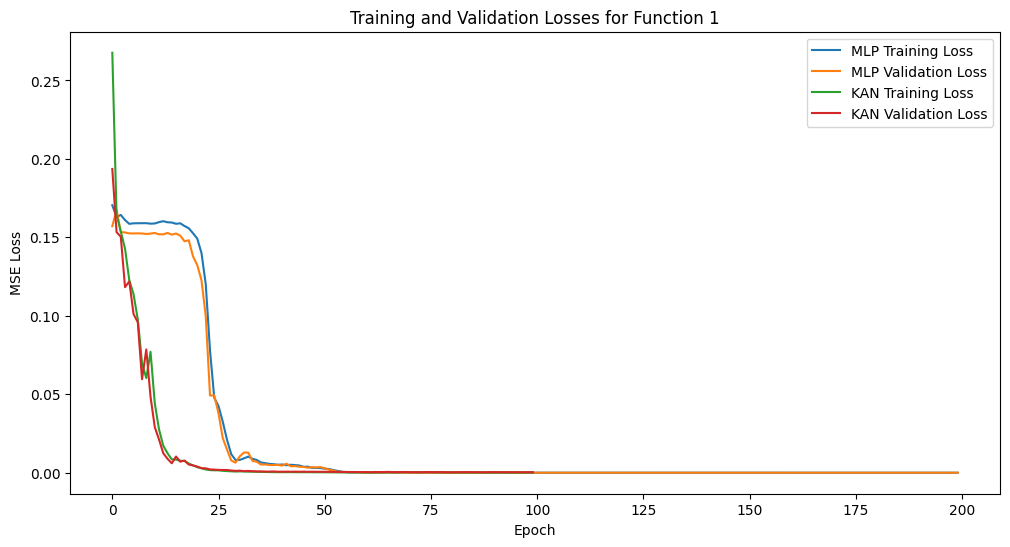

MLP Test MSE Loss: 0.000015
MLP Test MAE: 0.002914
MLP Test R^2 Score: 0.999899
KAN Test MSE Loss: 0.000353
KAN Test MAE: 0.011979
KAN Test R^2 Score: 0.997607


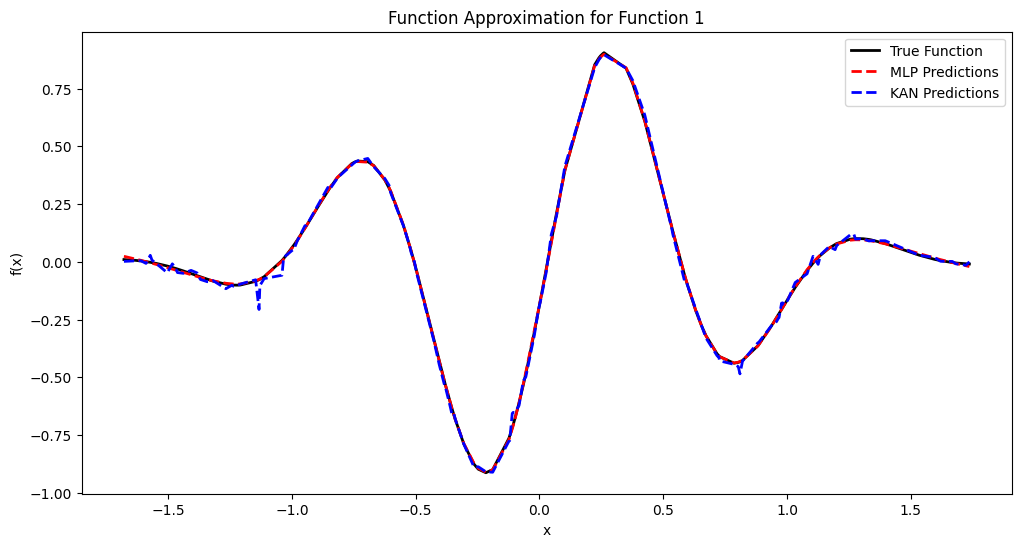

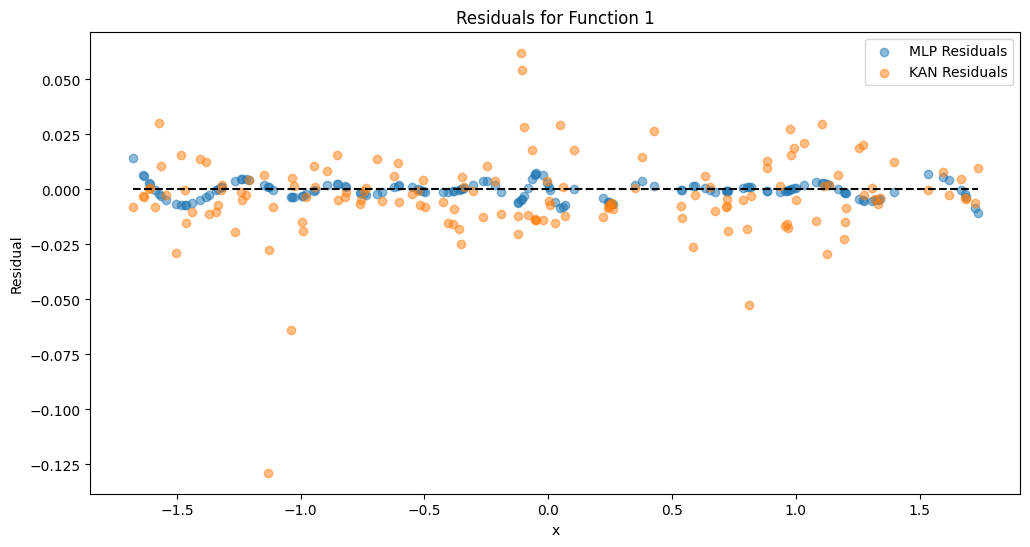

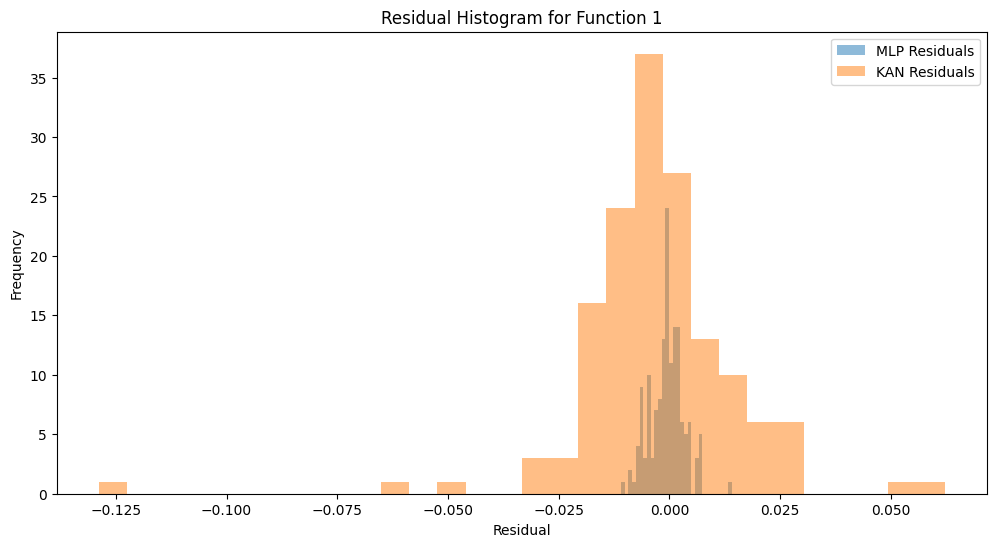


Processing Function 2...
Training MLP Model...


Training:  33%|███▎      | 66/200 [00:01<00:02, 55.15it/s]


Early stopping triggered.
Training KAN Model...


Training:  19%|█▉        | 38/200 [00:01<00:05, 28.67it/s]


Early stopping triggered.

Results for Function 2:


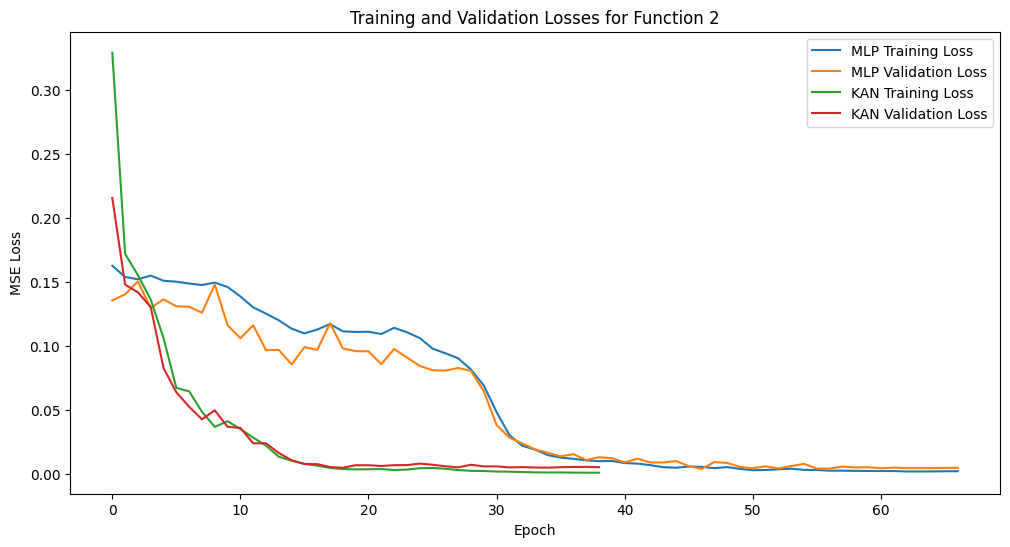

MLP Test MSE Loss: 0.003206
MLP Test MAE: 0.032947
MLP Test R^2 Score: 0.977988
KAN Test MSE Loss: 0.002311
KAN Test MAE: 0.030390
KAN Test R^2 Score: 0.984133


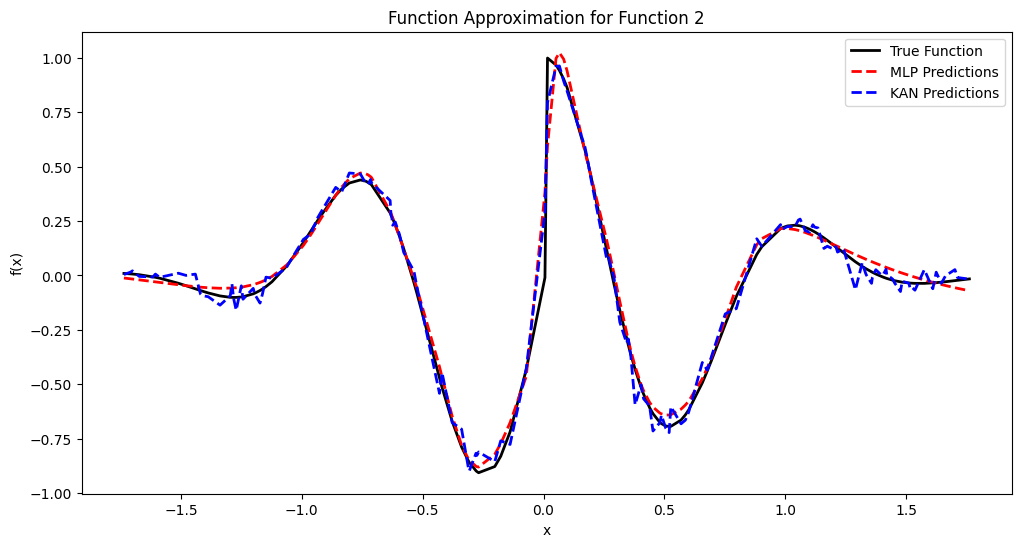

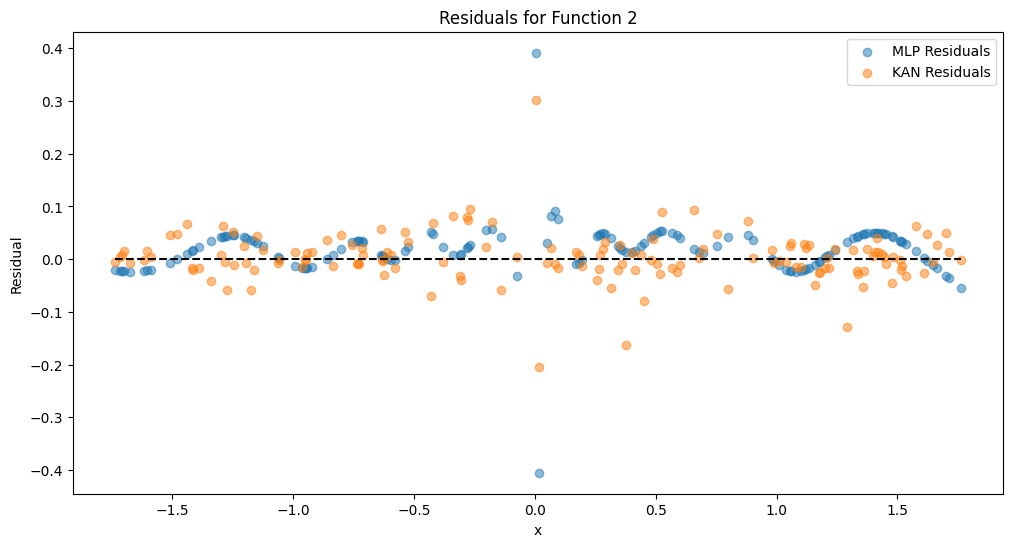

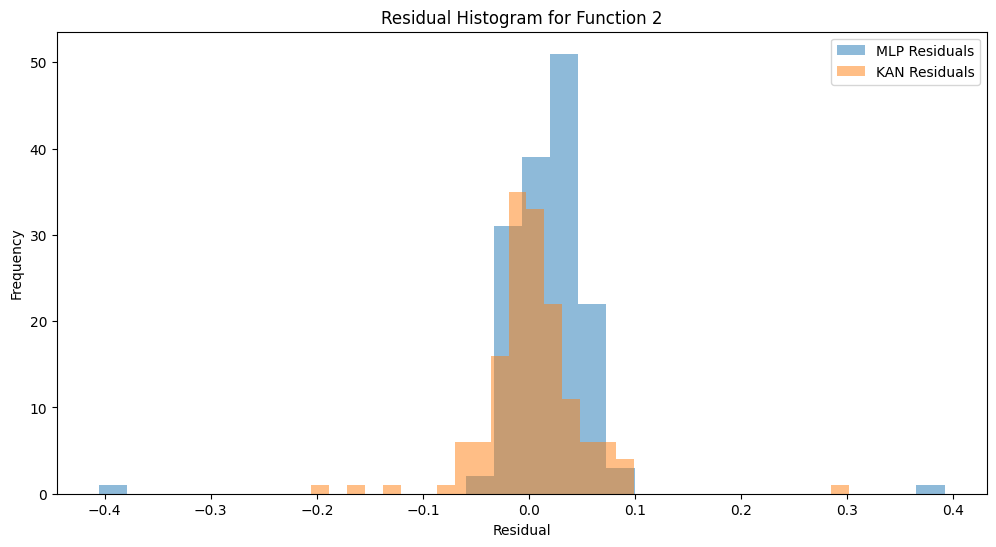


Processing Function 3...
Training MLP Model...


Training:  12%|█▏        | 23/200 [00:00<00:03, 57.72it/s]


Early stopping triggered.
Training KAN Model...


Training:  32%|███▏      | 64/200 [00:02<00:04, 29.71it/s]


Early stopping triggered.

Results for Function 3:


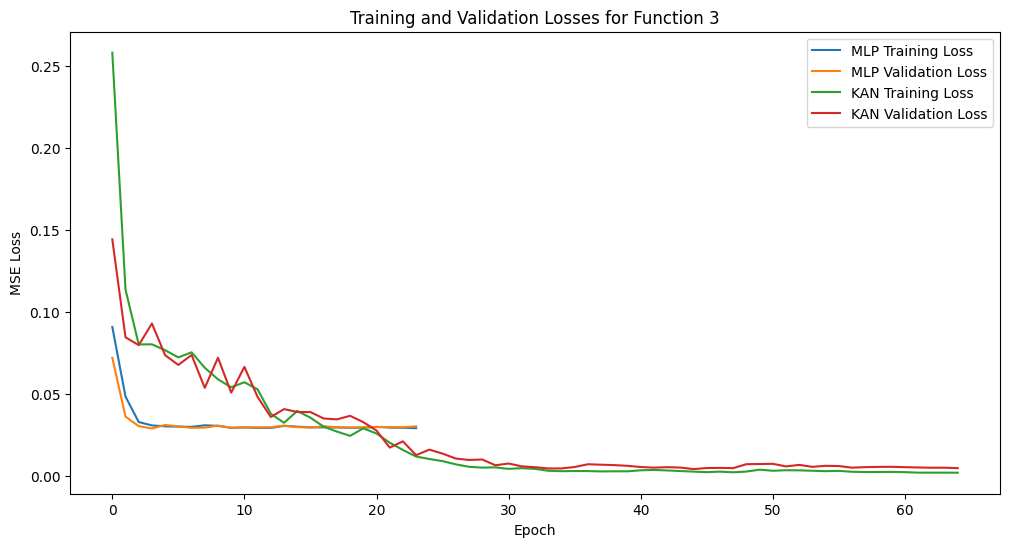

MLP Test MSE Loss: 0.031738
MLP Test MAE: 0.124313
MLP Test R^2 Score: 0.496085
KAN Test MSE Loss: 0.003526
KAN Test MAE: 0.040037
KAN Test R^2 Score: 0.944014


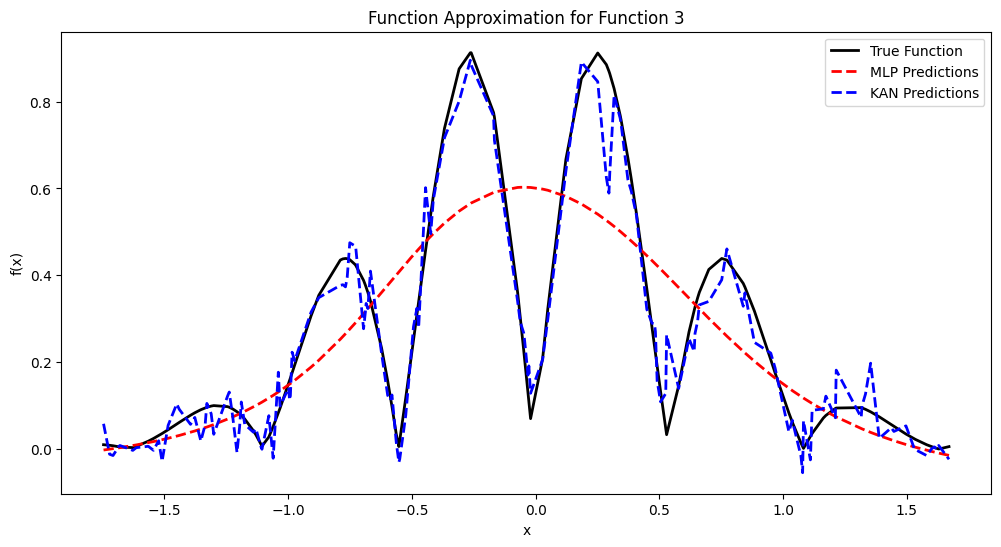

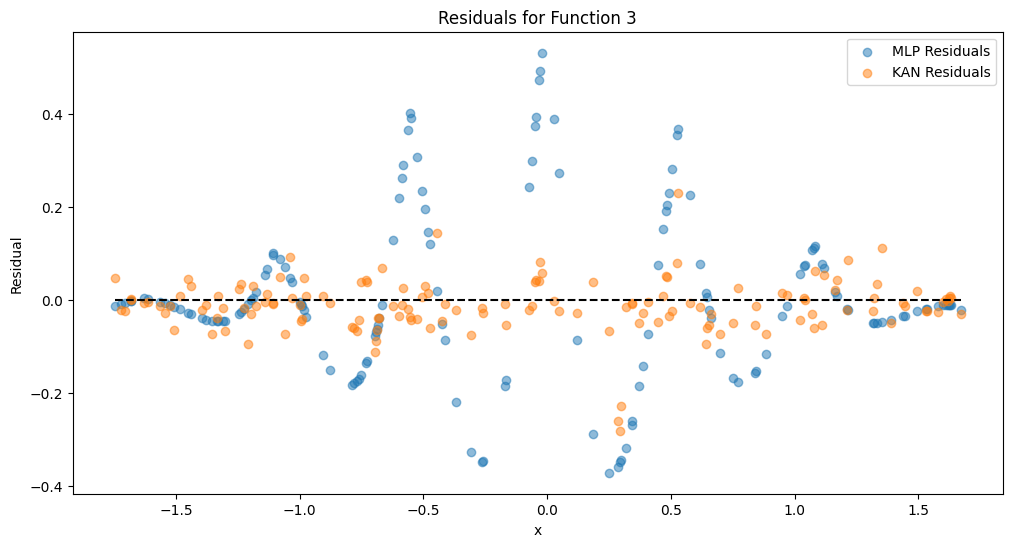

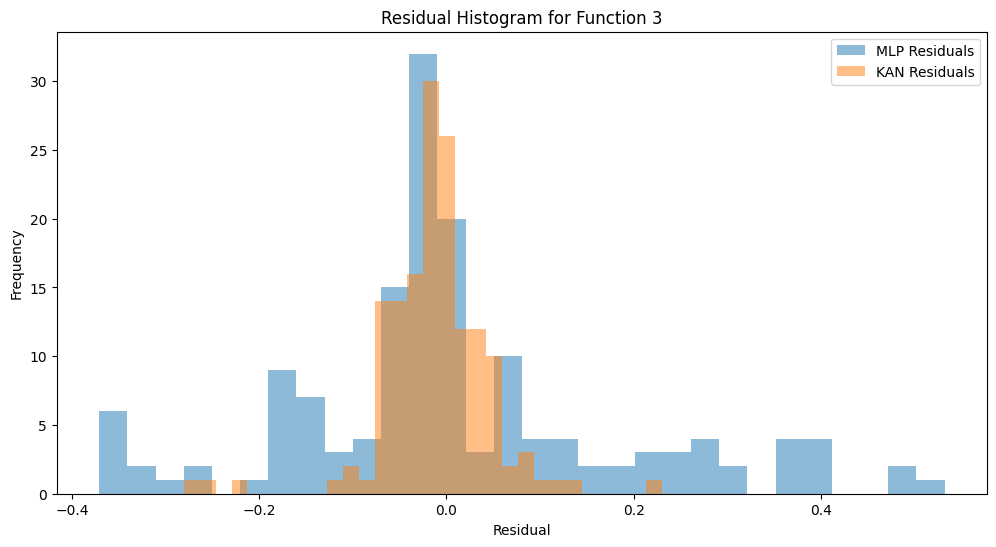


Processing Function 4...
Training MLP Model...


Training:  10%|█         | 20/200 [00:00<00:03, 54.79it/s]


Early stopping triggered.
Training KAN Model...


Training:  80%|████████  | 161/200 [00:05<00:01, 29.63it/s]


Early stopping triggered.

Results for Function 4:


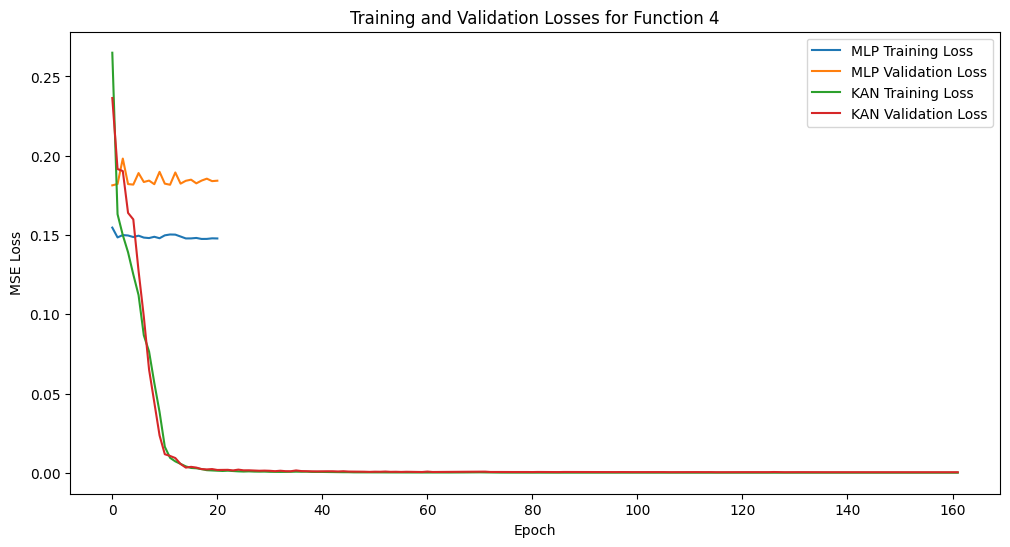

MLP Test MSE Loss: 0.171076
MLP Test MAE: 0.299311
MLP Test R^2 Score: 0.000925
KAN Test MSE Loss: 0.000436
KAN Test MAE: 0.014518
KAN Test R^2 Score: 0.997456


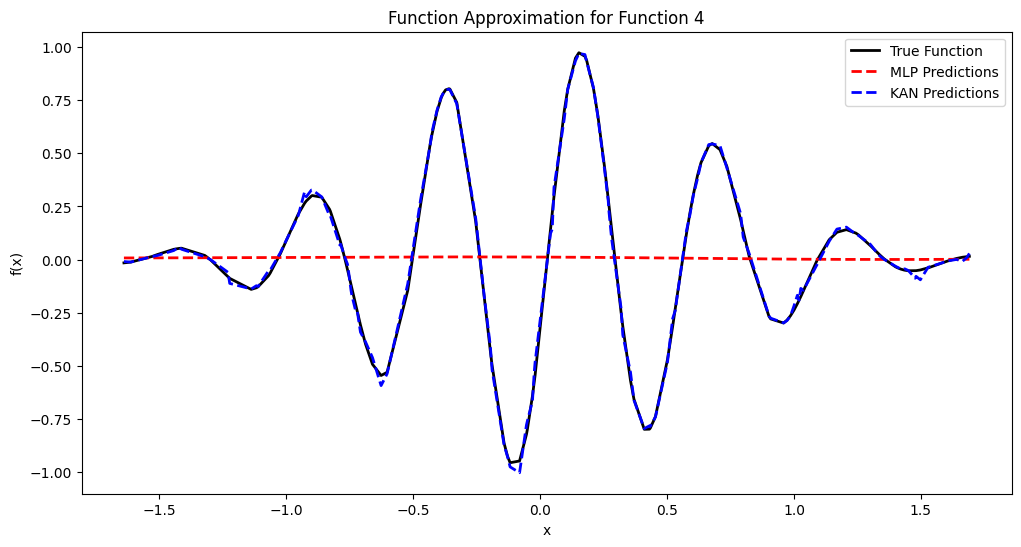

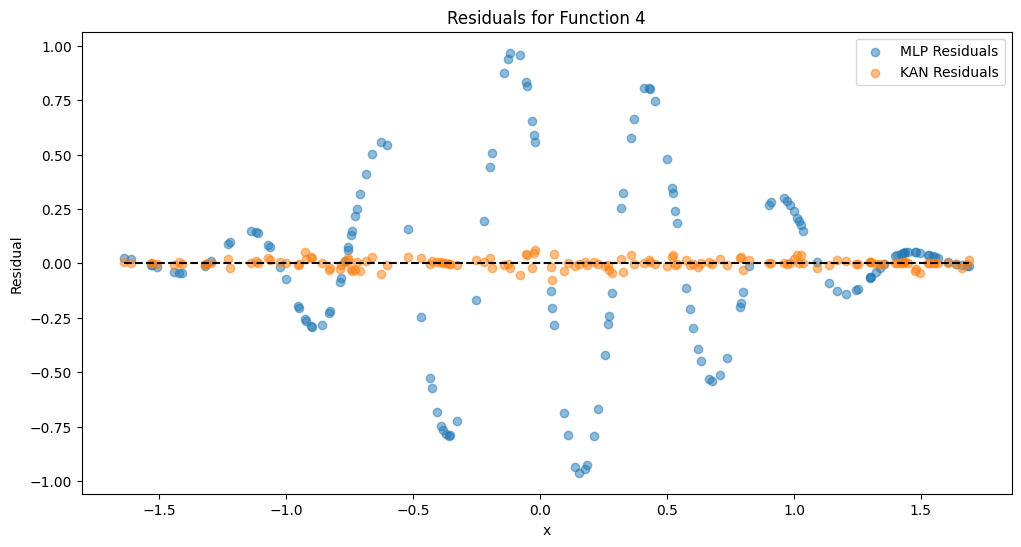

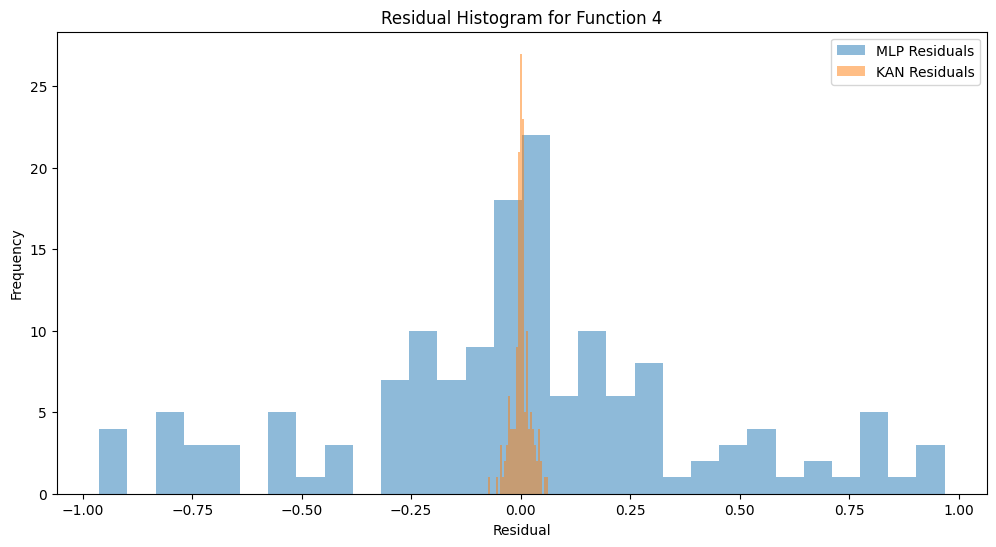


Processing Function 5...
Training MLP Model...


Training:  26%|██▌       | 51/200 [00:00<00:02, 57.51it/s]


Early stopping triggered.
Training KAN Model...


Training:  54%|█████▎    | 107/200 [00:03<00:03, 28.60it/s]


Early stopping triggered.

Results for Function 5:


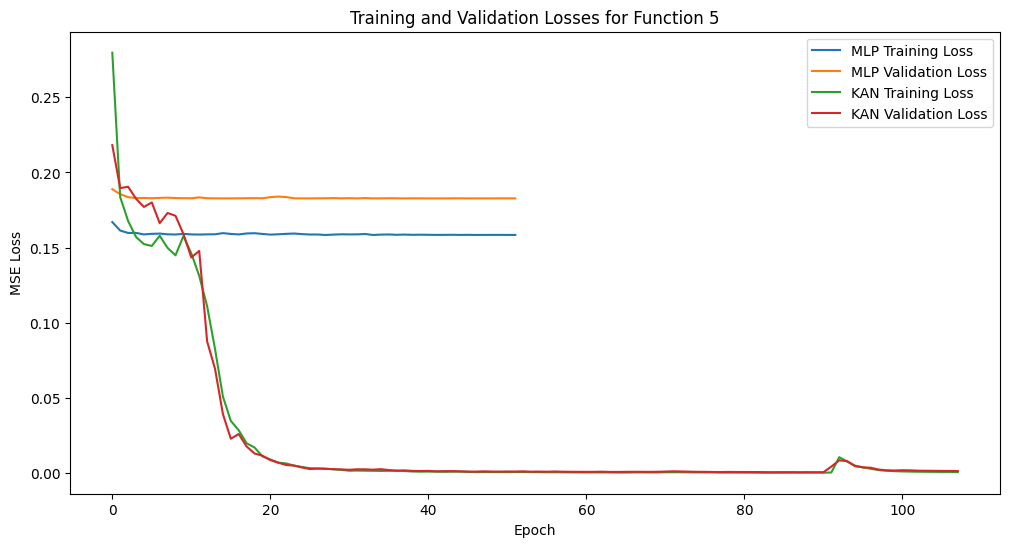

MLP Test MSE Loss: 0.121432
MLP Test MAE: 0.250863
MLP Test R^2 Score: -0.002853
KAN Test MSE Loss: 0.001178
KAN Test MAE: 0.024445
KAN Test R^2 Score: 0.990275


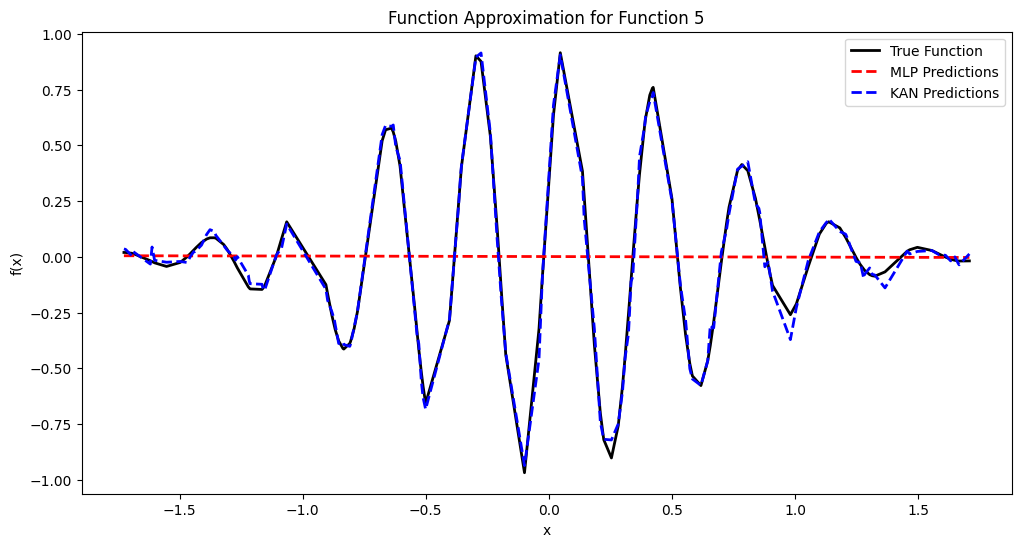

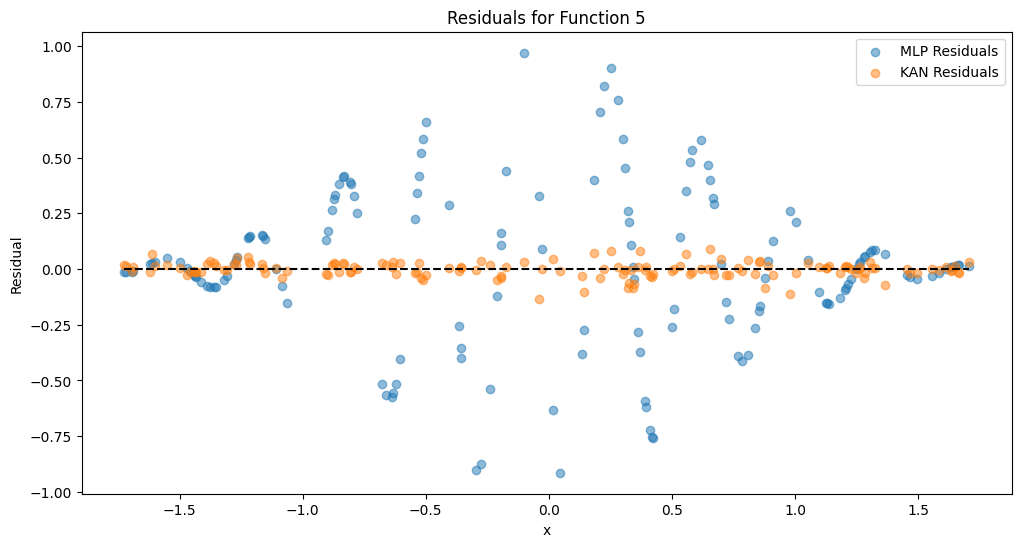

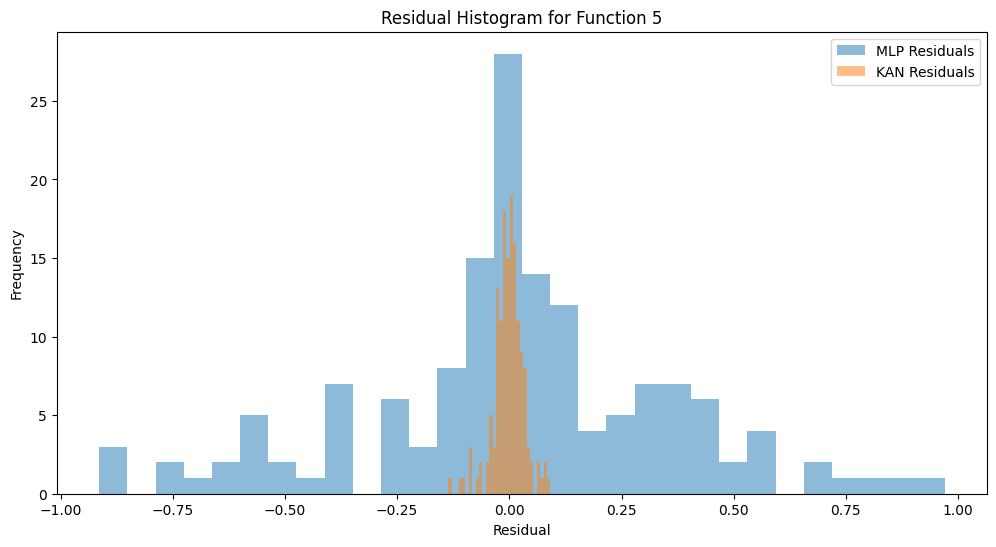


Processing Function 6...
Training MLP Model...


Training: 100%|██████████| 200/200 [00:03<00:00, 53.95it/s]


Training KAN Model...


Training:  58%|█████▊    | 116/200 [00:03<00:02, 29.22it/s]


Early stopping triggered.

Results for Function 6:


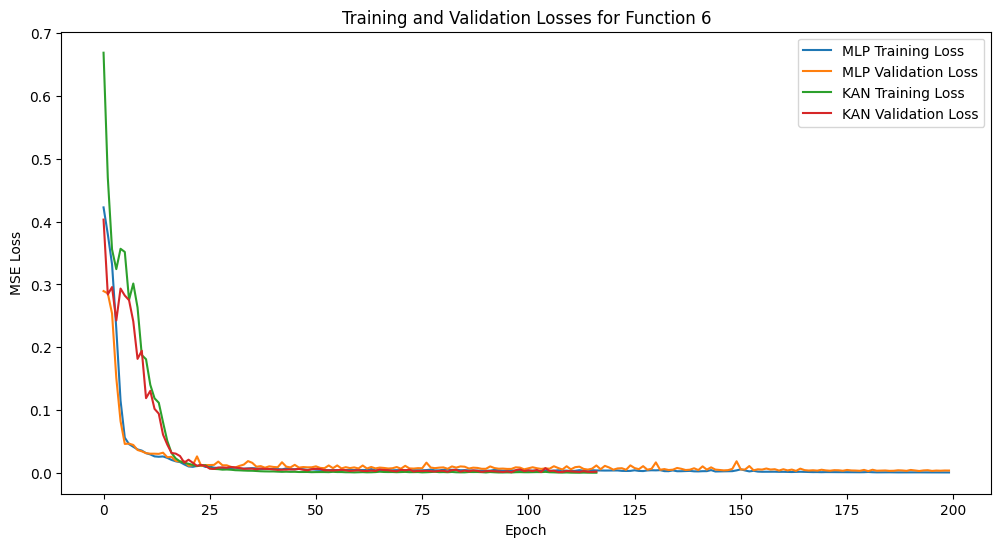

MLP Test MSE Loss: 0.000265
MLP Test MAE: 0.011647
MLP Test R^2 Score: 0.999130
KAN Test MSE Loss: 0.001090
KAN Test MAE: 0.022690
KAN Test R^2 Score: 0.996420


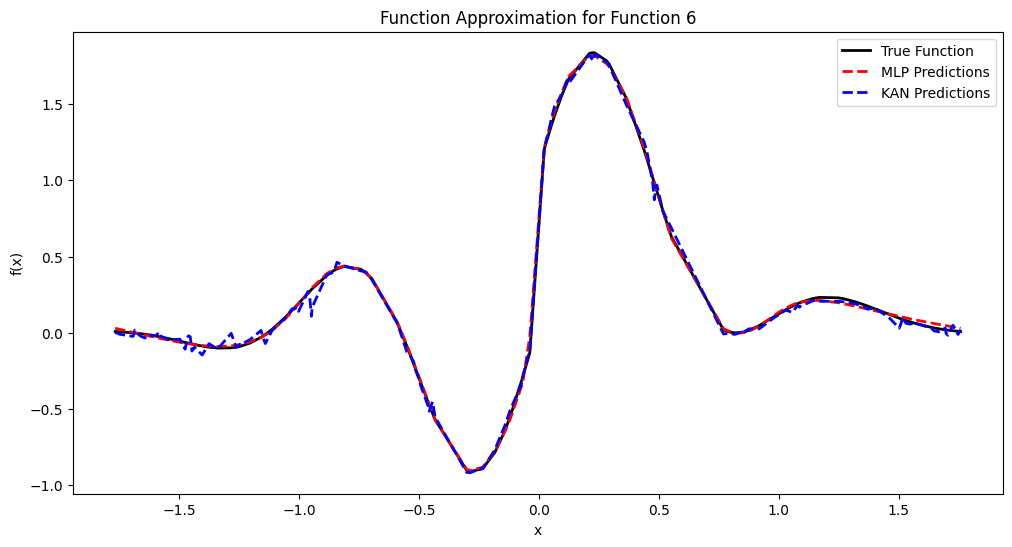

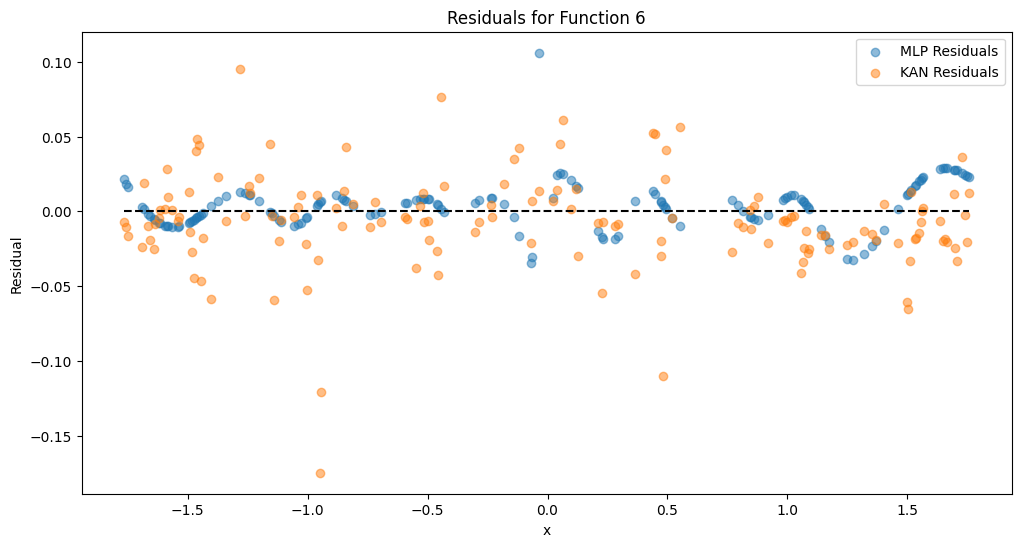

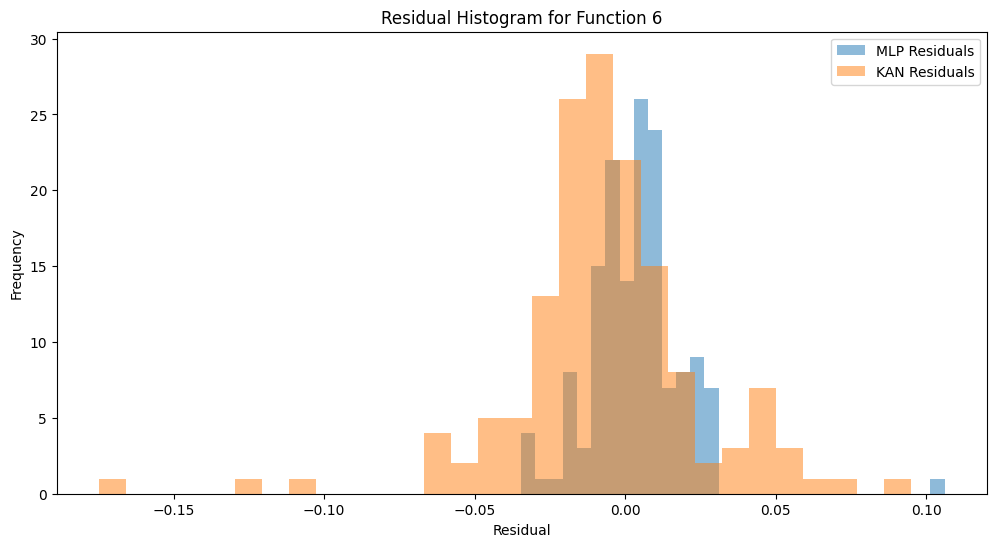

In [15]:
# Define criterion
criterion = nn.MSELoss()

# Store results for all functions
results = {}

for func_name, func in functions.items():
    print(f"\nProcessing {func_name}...")

    # Generate data
    train_loader, val_loader, test_loader, x_test, y_test = generate_data(func)

    # Initialize models
    mlp_model = MLP().to(device)
    kan_model = KAN().to(device)

    # Optimizers
    mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)
    kan_optimizer = optim.Adam(kan_model.parameters(), lr=0.01)

    # Train MLP Model
    print("Training MLP Model...")
    mlp_train_losses, mlp_val_losses = train_model(
        mlp_model, mlp_optimizer, criterion, train_loader, val_loader
    )
    mlp_test_loss, mlp_preds, mlp_trues = evaluate_model(mlp_model, criterion, test_loader)
    mlp_mae = mean_absolute_error(mlp_trues, mlp_preds)
    mlp_r2 = r2_score(mlp_trues, mlp_preds)

    # Train KAN Model
    print("Training KAN Model...")
    kan_train_losses, kan_val_losses = train_model(
        kan_model, kan_optimizer, criterion, train_loader, val_loader
    )
    kan_test_loss, kan_preds, kan_trues = evaluate_model(kan_model, criterion, test_loader)
    kan_mae = mean_absolute_error(kan_trues, kan_preds)
    kan_r2 = r2_score(kan_trues, kan_preds)

    # Store results
    results[func_name] = {
        'MLP': {
            'train_losses': mlp_train_losses,
            'val_losses': mlp_val_losses,
            'test_loss': mlp_test_loss,
            'mae': mlp_mae,
            'r2': mlp_r2,
            'preds': mlp_preds,
            'trues': mlp_trues,
        },
        'KAN': {
            'train_losses': kan_train_losses,
            'val_losses': kan_val_losses,
            'test_loss': kan_test_loss,
            'mae': kan_mae,
            'r2': kan_r2,
            'preds': kan_preds,
            'trues': kan_trues,
        },
        'x_test': x_test,
        'y_test': y_test,
    }

    # Plotting results
    print(f"\nResults for {func_name}:")

    # Extract data
    mlp_train_losses = results[func_name]['MLP']['train_losses']
    mlp_val_losses = results[func_name]['MLP']['val_losses']
    kan_train_losses = results[func_name]['KAN']['train_losses']
    kan_val_losses = results[func_name]['KAN']['val_losses']

    # Plot Training and Validation Losses
    plt.figure(figsize=(12, 6))
    plt.plot(mlp_train_losses, label='MLP Training Loss')
    plt.plot(mlp_val_losses, label='MLP Validation Loss')
    plt.plot(kan_train_losses, label='KAN Training Loss')
    plt.plot(kan_val_losses, label='KAN Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f'Training and Validation Losses for {func_name}')
    plt.legend()
    plt.show()

    # Test Metrics
    print(f"MLP Test MSE Loss: {results[func_name]['MLP']['test_loss']:.6f}")
    print(f"MLP Test MAE: {results[func_name]['MLP']['mae']:.6f}")
    print(f"MLP Test R^2 Score: {results[func_name]['MLP']['r2']:.6f}")

    print(f"KAN Test MSE Loss: {results[func_name]['KAN']['test_loss']:.6f}")
    print(f"KAN Test MAE: {results[func_name]['KAN']['mae']:.6f}")
    print(f"KAN Test R^2 Score: {results[func_name]['KAN']['r2']:.6f}")

    # Plot Predictions vs True Function
    x_test = results[func_name]['x_test']
    y_test = results[func_name]['y_test']
    mlp_preds = results[func_name]['MLP']['preds']
    kan_preds = results[func_name]['KAN']['preds']

    # Sort for plotting
    sorted_indices = np.argsort(x_test)
    x_test_sorted = x_test[sorted_indices]
    y_test_sorted = y_test[sorted_indices]
    mlp_preds_sorted = mlp_preds[sorted_indices]
    kan_preds_sorted = kan_preds[sorted_indices]

    # Plot Predictions
    plt.figure(figsize=(12, 6))
    plt.plot(x_test_sorted, y_test_sorted, 'k-', label='True Function', linewidth=2)
    plt.plot(x_test_sorted, mlp_preds_sorted, 'r--', label='MLP Predictions', linewidth=2)
    plt.plot(x_test_sorted, kan_preds_sorted, 'b--', label='KAN Predictions', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title(f'Function Approximation for {func_name}')
    plt.legend()
    plt.show()

    # Plot Residuals
    plt.figure(figsize=(12, 6))
    plt.scatter(x_test, mlp_preds - y_test, alpha=0.5, label='MLP Residuals')
    plt.scatter(x_test, kan_preds - y_test, alpha=0.5, label='KAN Residuals')
    plt.hlines(0, x_test.min(), x_test.max(), colors='k', linestyles='dashed')
    plt.xlabel('x')
    plt.ylabel('Residual')
    plt.title(f'Residuals for {func_name}')
    plt.legend()
    plt.show()

    # Plot Histograms of Residuals
    plt.figure(figsize=(12,6))
    plt.hist(mlp_preds - y_test, bins=30, alpha=0.5, label='MLP Residuals')
    plt.hist(kan_preds - y_test, bins=30, alpha=0.5, label='KAN Residuals')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.title(f'Residual Histogram for {func_name}')
    plt.legend()
    plt.show()
